In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

import os
imgdir = 'output_images'
if not os.path.isdir(imgdir):
    os.mkdir(imgdir)

brands = ['Gummies', 'Sugar Buns', 'Sparkle Pop', 'Candys', 'Garlic Bombs', 'Snackmonds', 'Caffeinos', 'moon drops']
spend_types = ['Trade', 'Search', 'Display', 'TV', 'Radio']
num_brands, num_types = len(brands), len(spend_types)

In [2]:
np.random.seed(1)

In [3]:
import tqdm
try:
    tqdm_disp = tqdm.tqdm_notebook if get_ipython(
    ).__class__.__name__ == 'ZMQInteractiveShell' else tqdm.tqdm
except NameError:
    tqdm_disp = tqdm.tqdm

In [4]:
num_promos = 20000
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2018-06-01')
dates = pd.date_range(start_date, end_date)
num_dates = len(dates)

In [5]:
promo = pd.DataFrame(
    {'Brand':np.random.choice(brands, num_promos),
     'Type':np.random.choice(spend_types, num_promos), 
     'Spend':np.random.rand(num_promos) * 500,
     'date' : np.random.choice(dates, num_promos)})
promo = promo.groupby(['Brand', 'Type', 'date'])['Spend'].sum().to_frame()
promo = promo.unstack(fill_value=0).stack()
promo.shape

(35320, 1)

In [6]:
assert(promo.shape[0] == num_brands * num_types * num_dates)

In [7]:
true_baselines = {brand: [np.random.randn() * 100 + 1000] for brand in brands}

In [8]:
spend_rois = {t : [np.random.rand()+.8] for t in spend_types}
brand_rois = {t : [np.random.rand()/3] for t in brands}

In [9]:
brand_spend_combos = pd.DataFrame(
    data=np.random.rand(num_brands, num_types) - .5, index=brands, columns = spend_types)

In [10]:
brand_spend_combos  = brand_spend_combos + \
    pd.DataFrame(brand_rois, index=spend_rois).T + pd.DataFrame(spend_rois, index = brands)

In [11]:
brand_spend_combos

,Trade,Search,Display,TV,Radio
Gummies,1.379470,1.499302,1.078372,1.857534,1.437495
Sugar Buns,1.512642,1.146935,1.042279,1.719567,0.600809
Sparkle Pop,0.913438,1.853655,1.599055,1.105367,0.706626
Candys,0.875503,1.138967,0.903523,1.038180,1.165483
Garlic Bombs,1.072328,1.288699,1.529794,1.219882,1.341003
Snackmonds,1.748131,1.611227,0.894050,1.849508,1.167080
Caffeinos,1.413854,1.730278,0.632714,1.386630,0.864743
moon drops,1.322957,1.908252,1.222563,2.062672,0.946071


In [12]:
promo2 = promo.unstack(1)

In [13]:
promo2.columns = promo2.columns.droplevel(0)
promo2 = promo2.reset_index(1)

In [14]:
effect = promo2.copy()
effect[effect.columns[1:]] = effect[effect.columns[1:]] * brand_spend_combos
effect = effect.reset_index().set_index(['Brand', 'date'])
effect = effect.sum(1).to_frame(name='spend').unstack(0)
effect.columns = effect.columns.droplevel(0)

In [15]:
effect.head()

Brand,Caffeinos,Candys,Garlic Bombs,Gummies,Snackmonds,Sparkle Pop,Sugar Buns,moon drops
date,,,,,,,,
2016-01-01,1241.545053,1021.435624,265.201335,1875.182489,363.744795,826.979374,451.872600,528.913085
2016-01-02,735.043024,2023.492611,13.587615,475.131986,1531.025969,966.060874,1391.686578,930.233732
2016-01-03,113.875551,706.749626,472.515124,1814.794373,1200.971359,618.518054,545.827052,316.418583
2016-01-04,900.033186,232.770368,1058.022975,654.189540,546.501093,1115.479823,401.940077,724.712612
2016-01-05,337.163198,431.287917,1714.892938,219.252746,596.019496,629.327114,1039.279013,93.951082


In [16]:
salesnoise = pd.DataFrame(data = np.random.rand(num_dates, num_brands) * (-1), columns= brands, index=dates)
salesnoise.head()

,Gummies,Sugar Buns,Sparkle Pop,Candys,Garlic Bombs,Snackmonds,Caffeinos,moon drops
2016-01-01,-0.065436,-0.943707,-0.550973,-0.331595,-0.735017,-0.376583,-0.644862,-0.841947
2016-01-02,-0.618208,-0.596389,-0.897007,-0.484040,-0.807245,-0.314185,-0.159676,-0.718314
2016-01-03,-0.916461,-0.349224,-0.443357,-0.688893,-0.810267,-0.090313,-0.570398,-0.560280
2016-01-04,-0.132932,-0.252691,-0.349778,-0.347304,-0.200018,-0.952500,-0.835873,-0.329701
2016-01-05,-0.443875,-0.685256,-0.801273,-0.343564,-0.868019,-0.020303,-0.042897,-0.911604


In [17]:
seasonal_effects = pd.DataFrame(
    {brand: {'cos':np.random.randn() * 30000, 'sin':np.random.randn()*30000} for brand in brands})

In [18]:
seasonal_effects

,Gummies,Sugar Buns,Sparkle Pop,Candys,Garlic Bombs,Snackmonds,Caffeinos,moon drops
cos,-20659.536867,1983.968436,6369.566387,-41422.753634,-17022.799824,4243.397015,31328.214483,10881.683382
sin,-11967.853277,-49518.985949,10864.746272,-15230.589932,37655.367323,-37084.352914,-13624.733498,37420.248513


In [19]:
seasonal_effects.T

,cos,sin
Gummies,-20659.536867,-11967.853277
Sugar Buns,1983.968436,-49518.985949
Sparkle Pop,6369.566387,10864.746272
Candys,-41422.753634,-15230.589932
Garlic Bombs,-17022.799824,37655.367323
Snackmonds,4243.397015,-37084.352914
Caffeinos,31328.214483,-13624.733498
moon drops,10881.683382,37420.248513


In [20]:
brand_spend_combos

,Trade,Search,Display,TV,Radio
Gummies,1.379470,1.499302,1.078372,1.857534,1.437495
Sugar Buns,1.512642,1.146935,1.042279,1.719567,0.600809
Sparkle Pop,0.913438,1.853655,1.599055,1.105367,0.706626
Candys,0.875503,1.138967,0.903523,1.038180,1.165483
Garlic Bombs,1.072328,1.288699,1.529794,1.219882,1.341003
Snackmonds,1.748131,1.611227,0.894050,1.849508,1.167080
Caffeinos,1.413854,1.730278,0.632714,1.386630,0.864743
moon drops,1.322957,1.908252,1.222563,2.062672,0.946071


In [21]:
brand_spend_combos_with_seasonality = brand_spend_combos.join(seasonal_effects.T)

In [88]:
seasonal = salesnoise.index.dayofyear

seasonal_sine, seasonal_cos = np.sin(seasonal*2*np.pi/365), np.cos(seasonal*2*np.pi/365)

In [89]:
seasonal_effects

,Gummies,Sugar Buns,Sparkle Pop,Candys,Garlic Bombs,Snackmonds,Caffeinos,moon drops
cos,-20659.536867,1983.968436,6369.566387,-41422.753634,-17022.799824,4243.397015,31328.214483,10881.683382
sin,-11967.853277,-49518.985949,10864.746272,-15230.589932,37655.367323,-37084.352914,-13624.733498,37420.248513


In [92]:
seasonal_effects

,Gummies,Sugar Buns,Sparkle Pop,Candys,Garlic Bombs,Snackmonds,Caffeinos,moon drops
cos,-20659.536867,1983.968436,6369.566387,-41422.753634,-17022.799824,4243.397015,31328.214483,10881.683382
sin,-11967.853277,-49518.985949,10864.746272,-15230.589932,37655.367323,-37084.352914,-13624.733498,37420.248513


In [93]:
seasonal_effects.loc[['cos'],:].values * np.expand_dims(seasonal_cos.values, 1)

array([[-20656.47593367,   1983.67448934,   6368.62266749, ...,
          4242.76831022,  31323.57287026,  10880.07114288],
       [-20647.29404073,   1982.79273744,   6365.79178715, ...,
          4240.88238134,  31309.64940657,  10875.23490417],
       [-20631.99390896,   1981.32344127,   6361.07458532, ...,
          4237.73978749,  31286.44821804,  10867.17609866],
       ...,
       [ 17509.80294279,  -1681.49443896,  -5398.46817447, ...,
         -3596.45262253, -26551.94381576,  -9222.67197595],
       [ 17695.94687828,  -1699.37013941,  -5455.85843265, ...,
         -3634.68593944, -26834.21331547,  -9320.71673767],
       [ 17876.8471228 ,  -1716.74227981,  -5511.63200223, ...,
         -3671.84222046, -27108.53125864,  -9415.99956986]])

In [23]:
seasonal_impact = seasonal_effects.loc[['cos'],:].values * np.expand_dims(seasonal_cos.values, 1) + \
    seasonal_effects.loc[['sin'],:].values * np.expand_dims(seasonal_sine.values, 1)

In [24]:
total_sales = effect + salesnoise + pd.DataFrame(true_baselines).iloc[0,:] + seasonal_impact

In [25]:
# total_sales = pd.DataFrame(
#     data=total_sales.values + np.expand_dims(sine.values, 1) + np.expand_dims(cos.values, 1),
#     index=total_sales.index, columns=total_sales.columns)

In [26]:
total_sales.head()

,Caffeinos,Candys,Garlic Bombs,Gummies,Snackmonds,Sparkle Pop,Sugar Buns,moon drops
date,,,,,,,,
2016-01-01,-18617.028625,3197.667902,7834.294584,-38786.031836,-15056.221498,5458.477633,32518.498883,13133.117270
2016-01-02,-19319.809452,3346.555332,7766.741086,-40430.317129,-13233.329158,4957.170151,33210.278820,14173.662508
2016-01-03,-20131.911320,1176.507924,8407.800881,-39322.212480,-12902.953975,3969.159624,32107.146346,14195.502101
2016-01-04,-19530.246070,-150.058980,9174.003179,-40700.802210,-12893.618985,3824.605124,31696.773346,15235.730859
2016-01-05,-20270.198633,-804.043851,10008.184864,-41342.262488,-12174.236377,2695.892704,32058.113707,15232.111827


In [27]:
total_sales = total_sales.stack().to_frame(name='sales')

In [28]:
total_sales.head()

sales
date                                 
2016-01-01 Caffeinos    -18617.028625
           Candys         3197.667902
           Garlic Bombs   7834.294584
           Gummies      -38786.031836
           Snackmonds   -15056.221498

In [29]:
promo_viewed = promo.unstack(1)
promo_viewed.columns = promo_viewed.columns.droplevel(0)
promo_viewed = promo_viewed.reset_index().sort_values('date').set_index(['date', 'Brand'])
promo_viewed.head(10)

Type                        Display       Radio      Search          TV  \
date       Brand                                                          
2016-01-01 Caffeinos       0.000000  234.516007  250.194649    0.000000   
           Snackmonds      0.000000    0.000000    0.000000    0.000000   
           Garlic Bombs  173.357586    0.000000    0.000000    0.000000   
           Sparkle Pop   258.811618  107.790305  181.780242    0.000000   
           Sugar Buns      0.000000   31.961518    0.000000    0.000000   
           Candys          0.000000   63.088411  541.607485  318.860318   
           moon drops      0.000000    0.000000   30.729612  133.618573   
           Gummies       498.200029  165.267969    0.000000    0.000000   
2016-01-02 moon drops      8.376369  196.393865  384.745021    0.000000   
           Snackmonds      0.000000   16.841139  425.158608  446.791190   

Type                          Trade  
date       Brand                     
2016-01-01 Caffeinos     428.504355  
           Snackmonds    208.076387  
           Garlic Bombs    0.000000  
           Sparkle Pop     0.000000  
           Sugar Buns    286.035940  
           Candys          0.000000  
           moon drops    147.141520  
           Gummies       797.672848  
2016-01-02 moon drops      0.000000  
           Snackmonds      0.000000

In [30]:
total_sales = total_sales - total_sales.min()
#total_sales = total_sales * 1000 / total_sales.max()

In [31]:
sales_viewed = total_sales.clip(0, np.inf)

In [32]:
data_viewed = promo_viewed.join(sales_viewed, on=['date', 'Brand'])

In [33]:
data_viewed.round(2).head(10)

Display   Radio  Search      TV   Trade     sales
date       Brand                                                          
2016-01-01 Caffeinos        0.00  234.52  250.19    0.00  428.50  29881.95
           Snackmonds       0.00    0.00    0.00    0.00  208.08  33442.75
           Garlic Bombs   173.36    0.00    0.00    0.00    0.00  56333.27
           Sparkle Pop    258.81  107.79  181.78    0.00    0.00  53957.45
           Sugar Buns       0.00   31.96    0.00    0.00  286.04  81017.47
           Candys           0.00   63.09  541.61  318.86    0.00  51696.64
           moon drops       0.00    0.00   30.73  133.62  147.14  61632.09
           Gummies        498.20  165.27    0.00    0.00  797.67   9712.94
2016-01-02 moon drops       8.38  196.39  384.75    0.00    0.00  62672.64
           Snackmonds       0.00   16.84  425.16  446.79    0.00  35265.65

In [34]:
sales_viewed.head(10)

sales
date                                 
2016-01-01 Caffeinos     29881.947252
           Candys        51696.643780
           Garlic Bombs  56333.270462
           Gummies        9712.944042
           Snackmonds    33442.754380
           Sparkle Pop   53957.453511
           Sugar Buns    81017.474761
           moon drops    61632.093148
2016-01-02 Caffeinos     29179.166426
           Candys        51845.531210

In [35]:
spend = data_viewed.drop('sales', 1)
Yraw = data_viewed[['sales']]
spend.head(10)

Display       Radio      Search          TV  \
date       Brand                                                          
2016-01-01 Caffeinos       0.000000  234.516007  250.194649    0.000000   
           Snackmonds      0.000000    0.000000    0.000000    0.000000   
           Garlic Bombs  173.357586    0.000000    0.000000    0.000000   
           Sparkle Pop   258.811618  107.790305  181.780242    0.000000   
           Sugar Buns      0.000000   31.961518    0.000000    0.000000   
           Candys          0.000000   63.088411  541.607485  318.860318   
           moon drops      0.000000    0.000000   30.729612  133.618573   
           Gummies       498.200029  165.267969    0.000000    0.000000   
2016-01-02 moon drops      8.376369  196.393865  384.745021    0.000000   
           Snackmonds      0.000000   16.841139  425.158608  446.791190   

                              Trade  
date       Brand                     
2016-01-01 Caffeinos     428.504355  
           Snackmonds    208.076387  
           Garlic Bombs    0.000000  
           Sparkle Pop     0.000000  
           Sugar Buns    286.035940  
           Candys          0.000000  
           moon drops    147.141520  
           Gummies       797.672848  
2016-01-02 moon drops      0.000000  
           Snackmonds      0.000000

In [36]:
seasonal_X = spend.reset_index()['date'].dt.dayofyear

sine_X, cos_X = np.sin(seasonal_X*2*np.pi/365), np.cos(seasonal_X*2*np.pi/365)
#sine_X = sine_X.to_frame('sine')
#cos_X = cos_X.to_frame('cos')

In [37]:
dummies = pd.get_dummies(spend.reset_index()['Brand'])
dummies = dummies.set_index(spend.index)

In [38]:

spend['cos'] = cos_X.values
spend['sin'] = sine_X.values

In [39]:
spend.reset_index().groupby('date')[['cos', 'sin']].max().head(10)

,cos,sin
date,,
2016-01-01,0.999852,0.017213
2016-01-02,0.999407,0.034422
2016-01-03,0.998667,0.051620
2016-01-04,0.997630,0.068802
2016-01-05,0.996298,0.085965
2016-01-06,0.994671,0.103102
2016-01-07,0.992749,0.120208
2016-01-08,0.990532,0.137279
2016-01-09,0.988023,0.154309


In [40]:
spend.reset_index().set_index('date')['Brand'].to_frame().head()

,Brand
date,
2016-01-01,Caffeinos
2016-01-01,Snackmonds
2016-01-01,Garlic Bombs
2016-01-01,Sparkle Pop
2016-01-01,Sugar Buns


In [41]:
def color_background(val):
    color = '' if val < 1 else 'lightgreen'
    return 'background-color: ' + color
def color_number(val):
    color = 'red' if val < 1 else ''
    return 'color: %s' % color

In [42]:
dummies.head().style.applymap(color_background).applymap(color_number)

In [43]:
dummies.head()

Caffeinos  Candys  Garlic Bombs  Gummies  Snackmonds  \
date       Brand                                                                
2016-01-01 Caffeinos             1       0             0        0           0   
           Snackmonds            0       0             0        0           1   
           Garlic Bombs          0       0             1        0           0   
           Sparkle Pop           0       0             0        0           0   
           Sugar Buns            0       0             0        0           0   

                         Sparkle Pop  Sugar Buns  moon drops  
date       Brand                                              
2016-01-01 Caffeinos               0           0           0  
           Snackmonds              0           0           0  
           Garlic Bombs            0           0           0  
           Sparkle Pop             1           0           0  
           Sugar Buns              0           1           0

In [44]:
dummy_spends = {}
for dummy in dummies.columns:
    brand_spend = pd.DataFrame(
        dummies[dummy].to_frame().values * spend.values, 
        index=spend.index, columns=['type:' + c + '_brand:' + dummy for c in spend.columns])
    dummy_spends[dummy] = brand_spend

In [45]:
Xraw = pd.concat((spend, dummies, *list(dummy_spends.values())), 1)

In [46]:
Xraw.head(10).tail(5).round()

Display  Radio  Search     TV  Trade  cos  sin  \
date       Brand                                                        
2016-01-01 Candys          0.0   63.0   542.0  319.0    0.0  1.0  0.0   
           moon drops      0.0    0.0    31.0  134.0  147.0  1.0  0.0   
           Gummies       498.0  165.0     0.0    0.0  798.0  1.0  0.0   
2016-01-02 moon drops      8.0  196.0   385.0    0.0    0.0  1.0  0.0   
           Snackmonds      0.0   17.0   425.0  447.0    0.0  1.0  0.0   

                       Caffeinos  Candys  Garlic Bombs  \
date       Brand                                         
2016-01-01 Candys              0       1             0   
           moon drops          0       0             0   
           Gummies             0       0             0   
2016-01-02 moon drops          0       0             0   
           Snackmonds          0       0             0   

                                 ...              type:Trade_brand:Sugar Buns  \
date       Brand                 ...                                            
2016-01-01 Candys                ...                                      0.0   
           moon drops            ...                                      0.0   
           Gummies               ...                                      0.0   
2016-01-02 moon drops            ...                                      0.0   
           Snackmonds            ...                                      0.0   

                       type:cos_brand:Sugar Buns  type:sin_brand:Sugar Buns  \
date       Brand                                                              
2016-01-01 Candys                            0.0                        0.0   
           moon drops                        0.0                        0.0   
           Gummies                           0.0                        0.0   
2016-01-02 moon drops                        0.0                        0.0   
           Snackmonds                        0.0                        0.0   

                       type:Display_brand:moon drops  \
date       Brand                                       
2016-01-01 Candys                                0.0   
           moon drops                            0.0   
           Gummies                               0.0   
2016-01-02 moon drops                            8.0   
           Snackmonds                            0.0   

                       type:Radio_brand:moon drops  \
date       Brand                                     
2016-01-01 Candys                              0.0   
           moon drops                          0.0   
           Gummies                             0.0   
2016-01-02 moon drops                        196.0   
           Snackmonds                          0.0   

                       type:Search_brand:moon drops  type:TV_brand:moon drops  \
date       Brand                                                                
2016-01-01 Candys                               0.0                       0.0   
           moon drops                          31.0                     134.0   
           Gummies                              0.0                       0.0   
2016-01-02 moon drops                         385.0                       0.0   
           Snackmonds                           0.0                       0.0   

                       type:Trade_brand:moon drops  type:cos_brand:moon drops  \
date       Brand                                                                
2016-01-01 Candys                              0.0                        0.0   
           moon drops                        147.0                        1.0   
           Gummies                             0.0                        0.0   
2016-01-02 moon drops                          0.0                        1.0   
           Snackmonds                          0.0                        0.0   

                       type:sin_brand:moon drops  
date       Brand       

In [47]:
xmeans, xstds = Xraw.mean(), Xraw.std()
ymeans, ystds = Yraw.mean(), Yraw.std()

In [48]:
xstds[spend.columns] = xstds[spend.columns] / 10
for col in xstds.index:
    if 'sin_' in col or 'cos_' in col:
        xstds[col] = xstds[col] / 10


In [49]:
xstds[brands] = xstds[brands] / 100

In [50]:
X = (Xraw - xmeans) / xstds
Y = (Yraw - ymeans)/ystds

In [51]:
X.round(2).head()

Display  Radio  Search    TV  Trade    cos  sin  \
date       Brand                                                           
2016-01-01 Caffeinos       -6.55   4.58    4.64 -6.46  13.64  13.88 -1.5   
           Snackmonds      -6.55  -6.44   -6.57 -6.46   3.25  13.88 -1.5   
           Garlic Bombs     1.53  -6.44   -6.57 -6.46  -6.55  13.88 -1.5   
           Sparkle Pop      5.51  -1.38    1.58 -6.46  -6.55  13.88 -1.5   
           Sugar Buns      -6.55  -4.94   -6.57 -6.46   6.93  13.88 -1.5   

                         Caffeinos  Candys  Garlic Bombs  \
date       Brand                                           
2016-01-01 Caffeinos        264.56  -37.79        -37.79   
           Snackmonds       -37.79  -37.79        -37.79   
           Garlic Bombs     -37.79  -37.79        264.56   
           Sparkle Pop      -37.79  -37.79        -37.79   
           Sugar Buns       -37.79  -37.79        -37.79   

                                   ...              \
date       Brand                   ...               
2016-01-01 Caffeinos               ...               
           Snackmonds              ...               
           Garlic Bombs            ...               
           Sparkle Pop             ...               
           Sugar Buns              ...               

                         type:Trade_brand:Sugar Buns  \
date       Brand                                       
2016-01-01 Caffeinos                           -0.19   
           Snackmonds                          -0.19   
           Garlic Bombs                        -0.19   
           Sparkle Pop                         -0.19   
           Sugar Buns                           3.10   

                         type:cos_brand:Sugar Buns  type:sin_brand:Sugar Buns  \
date       Brand                                                                
2016-01-01 Caffeinos                         -0.17                      -0.61   
           Snackmonds                        -0.17                      -0.61   
           Garlic Bombs                      -0.17                      -0.61   
           Sparkle Pop                       -0.17                      -0.61   
           Sugar Buns                        40.39                       0.07   

                         type:Display_brand:moon drops  \
date       Brand                                         
2016-01-01 Caffeinos                              -0.2   
           Snackmonds                             -0.2   
           Garlic Bombs                           -0.2   
           Sparkle Pop                            -0.2   
           Sugar Buns                             -0.2   

                         type:Radio_brand:moon drops  \
date       Brand                                       
2016-01-01 Caffeinos                            -0.2   
           Snackmonds                           -0.2   
           Garlic Bombs                         -0.2   
           Sparkle Pop                          -0.2   
           Sugar Buns                           -0.2   

                         type:Search_brand:moon drops  \
date       Brand                                        
2016-01-01 Caffeinos                             -0.2   
           Snackmonds                            -0.2   
           Garlic Bombs                          -0.2   
           Sparkle Pop                           -0.2   
           Sugar Buns                            -0.2   

                         type:TV_brand:moon drops  \
date       Brand                                    
2016-01-01 Caffeinos                         -0.2   
           Snackmonds                        -0.2   
           Garlic Bombs                      -0.2   
           Sparkle Pop                       -0.2   
           Sugar Buns                        -0.2   

                         type:Trade_brand:moon drops  \
date       Brand                                       
2016-01-01 Caffeinos                           

In [52]:
clf = Ridge(1e-5).fit(X, Y)

In [53]:
import tensorflow as tf
lr = tf.placeholder(tf.float32, ())
x_in = tf.placeholder(tf.float32, (None, X.shape[1]))
y_in = tf.placeholder(tf.float32, (None))
w = tf.Variable(np.random.randn(X.shape[1]), dtype=tf.float32)
b = tf.Variable(0, dtype=tf.float32)
yhat = tf.reduce_sum(x_in * tf.expand_dims(w, 0)) + b
loss = tf.reduce_mean(tf.square(y_in-yhat)) + 1e-15 * (tf.reduce_sum(tf.square(w)))

In [54]:
optim = tf.train.AdamOptimizer(lr).minimize(loss)

feed_dict = {
    x_in:X, y_in:Y
}

s = tf.Session()
s.run(tf.global_variables_initializer())
for i in range(1000):
    feed_dict[lr] = 1e0/np.sqrt(i+1)
    l, _ = s.run([loss, optim], feed_dict)
    if i % 100 == 0:
        print(l)

1.010574
1.0023466
1.0004202
1.0001106
1.0033056
1.0060511
1.0010471
1.0016612
1.0012832
0.99987876


In [55]:
optim = tf.contrib.opt.ScipyOptimizerInterface(
        loss, tol=0
    )
feed_dict = {
    x_in:X, y_in:Y
}

s = tf.Session()
s.run(tf.global_variables_initializer())

with tqdm_disp() as tq:
    y_hat_trace = []

    def loss_callback(y_hat, loss):
        y_hat_trace.append(y_hat)
        tq.update()
        tq.set_postfix_str('loss = %.6f' % (loss))

    optim.minimize(
        s,
        feed_dict=feed_dict,
        fetches=[yhat, loss],
        loss_callback=loss_callback,
    )
    y_hat = y_hat_trace[-1]

A Jupyter Widget

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.999865
  Number of iterations: 5
  Number of functions evaluations: 18



In [56]:
s.run(loss, feed_dict)

0.9998655

In [57]:
coef_tf = s.run(w)

In [58]:
clf.coef_

array([[ 8.98424264e-04,  8.22025769e-04,  1.27724253e-03,
         1.29411506e-03,  1.02549110e-03, -4.03164546e-03,
        -7.06522959e-03,  7.06615792e-06,  1.21969544e-05,
         8.28302358e-06,  8.71571141e-06,  5.12915330e-07,
         9.97348791e-06,  3.79230511e-06,  1.66743600e-05,
        -1.57117226e-03, -4.97684565e-04,  7.72203697e-04,
        -4.80216526e-04,  5.15196948e-04, -1.79677560e-02,
        -8.99996436e-03, -6.67695336e-04,  5.12644510e-04,
        -1.30422078e-03, -1.70135065e-03, -1.36539597e-03,
         3.28927798e-03, -4.51799529e-02,  1.46226128e-03,
         1.03191226e-03, -7.70203088e-04, -1.04236969e-03,
        -6.33015661e-04,  7.40635692e-03,  1.29988997e-02,
        -7.15878676e-05,  1.43570312e-03, -1.18648265e-05,
         1.16949726e-03,  3.86907404e-04, -3.74595879e-02,
        -1.21435843e-02, -7.00761614e-04,  5.15824960e-04,
         3.92082100e-04,  1.16888704e-03,  1.54187845e-03,
        -1.45536685e-02,  3.88112839e-02,  1.59878829e-0

In [59]:
coef = clf.coef_ / xstds.values * ystds.values
#coef = (np.expand_dims(coef_tf, 0) / xstds.values) * ystds.values

In [60]:
display = pd.DataFrame(coef, columns=X.columns)

In [61]:
aggregated = spend.columns
bias = dummies.columns
deltas = np.array([col for col in X.columns if col not in aggregated and col not in bias])

In [62]:
results = pd.DataFrame(
    data=np.zeros((num_brands+1, spend.columns.shape[0]+1)), 
    index=['aggregated'] + brands, columns = ['bias'] + list(spend.columns))

In [63]:
results

,bias,Display,Radio,Search,TV,Trade,cos,sin
aggregated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gummies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sugar Buns,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sparkle Pop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Candys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Garlic Bombs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Snackmonds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Caffeinos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
moon drops,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
results.loc[['aggregated'], aggregated]


,Display,Radio,Search,TV,Trade,cos,sin
aggregated,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
display[aggregated]

,Display,Radio,Search,TV,Trade,cos,sin
0,1.099227,1.014179,1.502693,1.523051,1.268218,-1519.86826,-2626.796431


In [66]:
display

,Display,Radio,Search,TV,Trade,cos,sin,Caffeinos,Candys,Garlic Bombs,...,type:Trade_brand:Sugar Buns,type:cos_brand:Sugar Buns,type:sin_brand:Sugar Buns,type:Display_brand:moon drops,type:Radio_brand:moon drops,type:Search_brand:moon drops,type:TV_brand:moon drops,type:Trade_brand:moon drops,type:cos_brand:moon drops,type:sin_brand:moon drops
0,1.099227,1.014179,1.502693,1.523051,1.268218,-1519.86826,-2626.796431,56.09809,96.831384,65.758763,...,0.244386,32848.066111,-10997.946015,0.123392,-0.068008,0.405583,0.539598,0.05475,12401.537403,40047.058824


In [67]:
display['type:Display_brand:Gummies']

0   -0.020882
Name: type:Display_brand:Gummies, dtype: float64

In [68]:
results.loc[['aggregated'], aggregated] = display[aggregated].values
for brand in brands:
    results.loc[brand, 'bias'] = display[brand].values
    results.loc[brand, aggregated] = display.loc[:,[b for b in deltas if brand in b]].values + display[aggregated].values

In [69]:
results

,bias,Display,Radio,Search,TV,Trade,cos,sin
aggregated,0.000000,1.099227,1.014179,1.502693,1.523051,1.268218,-1519.868260,-2626.796431
Gummies,69.193863,1.078345,1.437504,1.499319,1.857569,1.379449,-41422.737292,-15230.600820
Sugar Buns,30.107037,1.042211,0.600744,1.146943,1.719527,1.512605,31328.197851,-13624.742446
Sparkle Pop,79.179327,1.599065,0.706625,1.853671,1.105339,0.913436,4243.387238,-37084.367754
Candys,96.831384,0.903533,1.165509,1.138929,1.038177,0.875562,1983.951070,-49518.988536
Garlic Bombs,65.758763,1.529723,1.340914,1.288697,1.219992,1.072319,6369.564234,10864.738288
Snackmonds,4.072025,0.894066,1.167207,1.611288,1.849526,1.748050,-17022.791839,37655.365520
Caffeinos,56.098090,0.632648,0.864753,1.730260,1.386678,1.413942,-20659.561287,-11967.843298
moon drops,132.377420,1.222619,0.946171,1.908276,2.062649,1.322968,10881.669143,37420.262394


In [70]:
import calendar

In [71]:
def add_month(df):
    df = df.copy()

    df['phase'] = np.angle((
            df['sin'] * 1j + df['cos']).astype(complex))
    df['peak_month'] = ((
            (df['phase'] * 12 / 2 / np.pi)) % 12).round().astype(int)
    df.loc[df['peak_month'] == 0, 'peak_month'] = 12
    df['peak_month'] = df['peak_month'].apply(
        lambda x: calendar.month_abbr[x])
    df['seasonal_impact'] = np.sqrt(
        (np.square(df['sin']) + np.square(
            df['cos'])).astype('float'))
    df['seasonal_impact'] = (df[
        'seasonal_impact'] - df['seasonal_impact'].min()) / df['seasonal_impact'].std() + 0.1
    return df

In [72]:
groundtruth = add_month(brand_spend_combos_with_seasonality)
results2 = add_month(results)

In [73]:
groundtruth[list(aggregated) + ['peak_month', 'seasonal_impact']].round(2)

,Display,Radio,Search,TV,Trade,cos,sin,peak_month,seasonal_impact
Gummies,1.08,1.44,1.50,1.86,1.38,-20659.54,-11967.85,Jul,1.05
Sugar Buns,1.04,0.60,1.15,1.72,1.51,1983.97,-49518.99,Sep,3.22
Sparkle Pop,1.60,0.71,1.85,1.11,0.91,6369.57,10864.75,Feb,0.10
Candys,0.90,1.17,1.14,1.04,0.88,-41422.75,-15230.59,Jul,2.76
Garlic Bombs,1.53,1.34,1.29,1.22,1.07,-17022.80,37655.37,Apr,2.52
Snackmonds,0.89,1.17,1.61,1.85,1.75,4243.40,-37084.35,Sep,2.19
Caffeinos,0.63,0.86,1.73,1.39,1.41,31328.21,-13624.73,Nov,1.92
moon drops,1.22,0.95,1.91,2.06,1.32,10881.68,37420.25,Feb,2.33


In [74]:
results2[list(aggregated) + ['peak_month', 'seasonal_impact']].round(2)

,Display,Radio,Search,TV,Trade,cos,sin,peak_month,seasonal_impact
aggregated,1.10,1.01,1.50,1.52,1.27,-1519.87,-2626.80,Aug,0.10
Gummies,1.08,1.44,1.50,1.86,1.38,-41422.74,-15230.60,Jul,2.76
Sugar Buns,1.04,0.60,1.15,1.72,1.51,31328.20,-13624.74,Nov,2.12
Sparkle Pop,1.60,0.71,1.85,1.11,0.91,4243.39,-37084.37,Sep,2.32
Candys,0.90,1.17,1.14,1.04,0.88,1983.95,-49518.99,Sep,3.12
Garlic Bombs,1.53,1.34,1.29,1.22,1.07,6369.56,10864.74,Feb,0.72
Snackmonds,0.89,1.17,1.61,1.85,1.75,-17022.79,37655.37,Apr,2.58
Caffeinos,0.63,0.86,1.73,1.39,1.41,-20659.56,-11967.84,Jul,1.45
moon drops,1.22,0.95,1.91,2.06,1.32,10881.67,37420.26,Feb,2.43


In [75]:
display_aggregated = display.rename({col: 'aggregated:'+col for col in spend.columns}, axis=1)

In [76]:
display_aggregated

,aggregated:Display,aggregated:Radio,aggregated:Search,aggregated:TV,aggregated:Trade,aggregated:cos,aggregated:sin,Caffeinos,Candys,Garlic Bombs,...,type:Trade_brand:Sugar Buns,type:cos_brand:Sugar Buns,type:sin_brand:Sugar Buns,type:Display_brand:moon drops,type:Radio_brand:moon drops,type:Search_brand:moon drops,type:TV_brand:moon drops,type:Trade_brand:moon drops,type:cos_brand:moon drops,type:sin_brand:moon drops
0,1.099227,1.014179,1.502693,1.523051,1.268218,-1519.86826,-2626.796431,56.09809,96.831384,65.758763,...,0.244386,32848.066111,-10997.946015,0.123392,-0.068008,0.405583,0.539598,0.05475,12401.537403,40047.058824


In [77]:
X.columns.shape

(71,)

In [78]:
data_viewed.head()

Display       Radio      Search   TV       Trade  \
date       Brand                                                               
2016-01-01 Caffeinos       0.000000  234.516007  250.194649  0.0  428.504355   
           Snackmonds      0.000000    0.000000    0.000000  0.0  208.076387   
           Garlic Bombs  173.357586    0.000000    0.000000  0.0    0.000000   
           Sparkle Pop   258.811618  107.790305  181.780242  0.0    0.000000   
           Sugar Buns      0.000000   31.961518    0.000000  0.0  286.035940   

                                sales  
date       Brand                       
2016-01-01 Caffeinos     29881.947252  
           Snackmonds    33442.754380  
           Garlic Bombs  56333.270462  
           Sparkle Pop   53957.453511  
           Sugar Buns    81017.474761

In [79]:
def view_brand(df, b):
    plt.figure(figsize=(15, 10))
    brand = data_viewed.query('Brand == "' + b + '"')
    x = brand.reset_index()['date']
    for spend in brand.columns[-2:]:
        plt.plot(x, brand[spend]/brand[spend].max(), label=spend)
    sin = np.sin(x.dt.dayofyear * 2 * np.pi/365)
    cos = np.cos(x.dt.dayofyear * 2 * np.pi/365)
    plt.plot(x, sin, label='sine')
    plt.plot(x, cos, label='cos')
    plt.legend()
    plt.show()


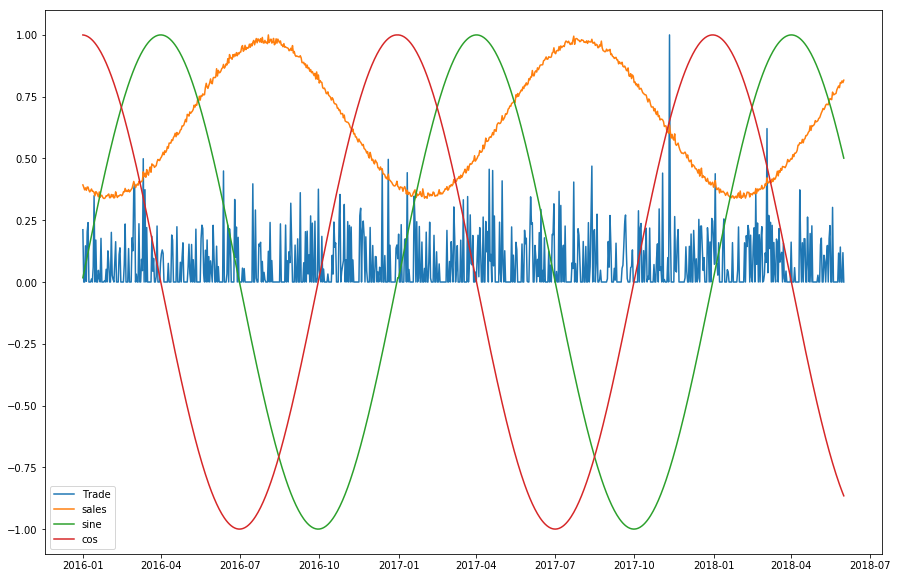

In [82]:
view_brand(data_viewed, 'Caffeinos')